In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import patsy as pat
import pytensor.tensor as pt

from bambi.plots import plot_cap

/home/tomas/anaconda3/envs/bambi_hsgp/lib/python3.10/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


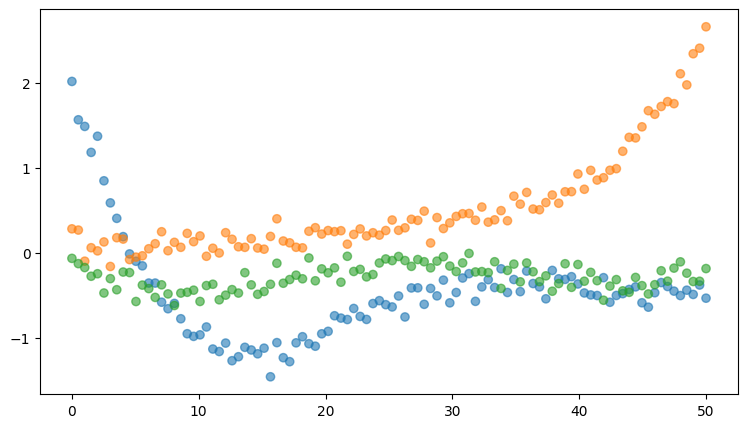

In [2]:
rng = np.random.default_rng(seed=3)

N = 100
x = np.linspace(0, 50, N)

df = 5
X = pat.dmatrix(f"bs(x, df={df}, degree=3, include_intercept=True) - 1", {"x": x})

Y, F = [], []
for i in range(3):
    b = 0.1 * rng.normal(size=df)
    f = 10 * X @ b
    sigma_t = 0.1
    y = f + sigma_t * rng.normal(size=len(x))
    F.append(f)
    Y.append(y)
F = np.vstack(F).T
Y = np.vstack(Y).T

data = pd.DataFrame(
    {
        "y": Y.reshape(300, order="F"),
        "x": np.tile(x, 3),
        "group": np.repeat(list("ABC"), 100)
    }
)

fig, ax = plt.subplots(figsize = (9, 5))
colors = [f"C{i}" for i in pd.Categorical(data["group"]).codes]
ax.scatter(data["x"], data["y"], color=colors, alpha=0.6);

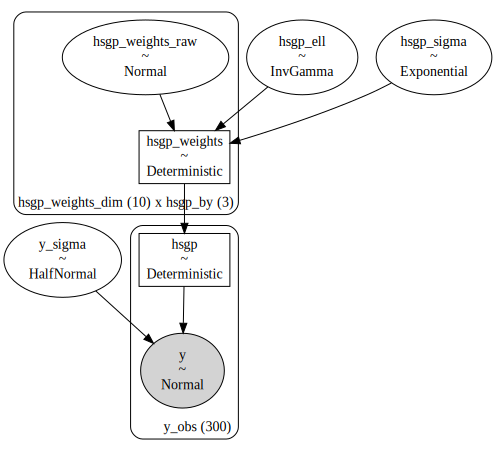

In [3]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=2),
    "ell": bmb.Prior("InverseGamma", mu=10, sigma=1)
}
priors = {
    "hsgp(x, by=group, m=10, c=2)": prior_hsgp,
    "sigma": bmb.Prior("HalfNormal", sigma=1)
}
model = bmb.Model("y ~ 0 + hsgp(x, by=group, m=10, c=2)", data, priors=priors)
model.set_alias({"hsgp(x, by=group, m=10, c=2)": "hsgp"})
model.build()
model.graph()

In [4]:
idata = model.fit(inference_method="nuts_numpyro")

Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:03.011220
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:08.054031
Transforming variables...
Transformation time =  0:00:00.802917


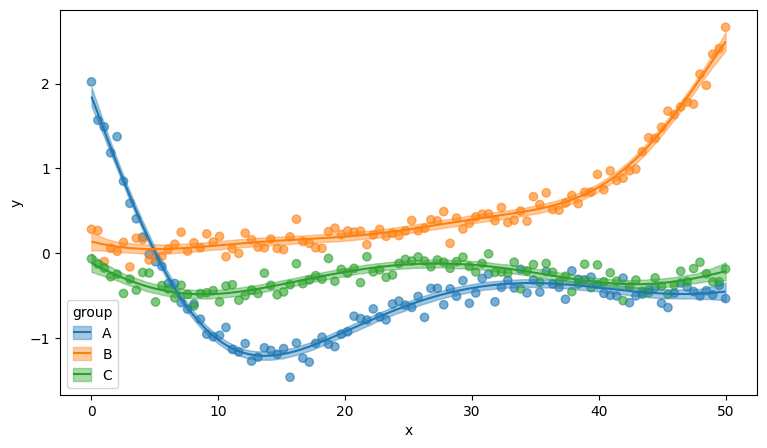

In [5]:
fig, ax = plt.subplots(figsize = (9, 5))

colors = [f"C{i}" for i in pd.Categorical(data["group"]).codes]
ax.scatter(data["x"], data["y"], color=colors, alpha=0.6);
plot_cap(model, idata, ["x", "group"], ax=ax);

Let's shuffle the rows...

In [6]:
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,y,x,group
0,-0.104472,47.979798,C
1,-0.468005,45.959596,A
2,-0.117670,35.858586,C
3,-0.058916,18.686869,C
4,-0.212954,35.858586,A


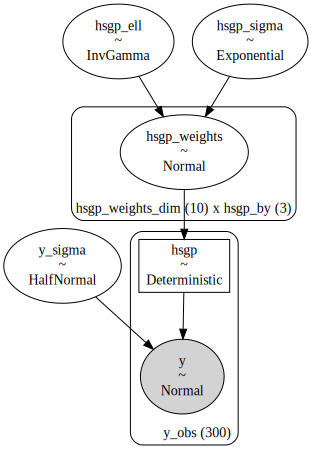

In [7]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=2),
    "ell": bmb.Prior("InverseGamma", mu=10, sigma=1)
}
priors = {
    "hsgp(x, by=group, m=10, c=2, centered=True)": prior_hsgp,
    "sigma": bmb.Prior("HalfNormal", sigma=1)
}
model = bmb.Model("y ~ 0 + hsgp(x, by=group, m=10, c=2, centered=True)", data, priors=priors)
model.set_alias({"hsgp(x, by=group, m=10, c=2, centered=True)": "hsgp"})
model.build()
model.graph()

In [8]:
idata = model.fit(inference_method="nuts_numpyro")

Compiling...
Compilation time =  0:00:03.886424
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:09.462689
Transforming variables...
Transformation time =  0:00:00.036179


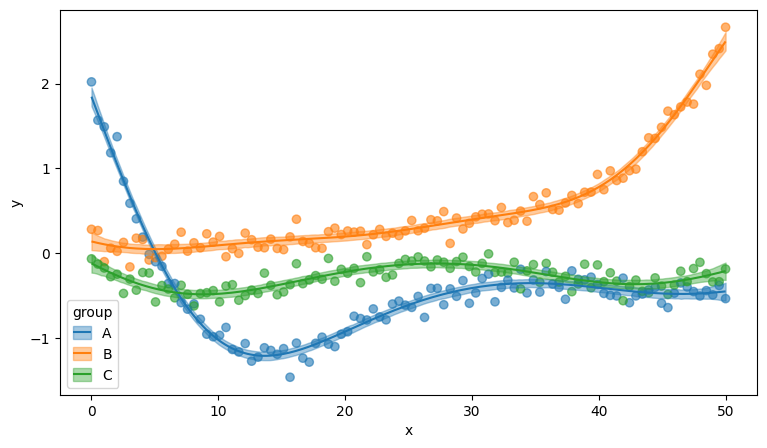

In [9]:
fig, ax = plt.subplots(figsize = (9, 5))

colors = [f"C{i}" for i in pd.Categorical(data["group"]).codes]
ax.scatter(data["x"], data["y"], color=colors, alpha=0.6);
plot_cap(model, idata, ["x", "group"], ax=ax);